In [1]:
import math
import itertools
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import einops as E
import torch
import os

from pathlib import Path
from models import utils as mutils
import sampling as sampling
from sde_lib import VESDE
from sampling import (ReverseDiffusionPredictor,
                    LangevinCorrector,
                    LangevinCorrectorCS)
from models import ncsnpp
from itertools import islice
from losses import get_optimizer
import datasets as datasets
import time
import controllable_generation_TV as controllable_generation_TV
from utils import restore_checkpoint, fft2, ifft2, show_samples_gray, get_mask, clear
import torch.nn as nn
from models.ema import ExponentialMovingAverage
from scipy.io import savemat, loadmat
import importlib
import torchvision

from torchvision.transforms import Resize

/root/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_gpu=0
os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % m_gpu
torch.cuda.set_device(m_gpu)
torch.cuda.is_available()
torch.cuda.current_device()
device = torch.device(torch.cuda.current_device())
print("device now: ", device)

device now:  cuda:0


In [3]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
        axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

In [5]:
def eval(catgory = 10, acc_factor = 6.0, center_fraction = 0.15):
  import UniverSeg.example_data.oasis
  import UniverSeg.example_data as example_data

  # catgory = 8 12 13 (17*) (23**)
  # catgory = 10 ############################################################ 类别
  d_support = example_data.oasis.OASISDataset('support', label=catgory)
  d_test = example_data.oasis.OASISDataset('test', label=catgory)

  support_images, support_labels = zip(*itertools.islice(d_support, 10))
  support_images = torch.stack(support_images).to(device)
  support_labels = torch.stack(support_labels).to(device)

  # select an image, label test pair
  idx = np.random.permutation(len(d_test))[0]
  image, label = d_test[idx]
  image, label = image.to(device), label.to(device)

  # 统一resize到240
  from torchvision.transforms import Resize
  torch_resize = Resize([240,240])
  image = torch_resize(image)
  support_images = torch_resize(support_images)
  label = torch_resize(label)
  support_labels = torch_resize(support_labels)


  ###############################################
  # Configurations
  ###############################################
  num_scales = 1000
  ckpt_num = 95
  N = num_scales

  img_size = 240
  h = w = 240
  batch_size = 1

  # parameters for Fourier CS recon
  mask_type = 'uniform1d'

  ######################################################################################################
  img = image.unsqueeze(dim=0)
  all_img = img
  print("归一化前:")
  print(all_img.size())
  print(all_img.mean())

  print("原始image信息:")
  print(image.size())
  print(image.mean())

  # normalize the volume to be in proper range
  vmax = all_img.max()
  all_img /= (vmax + 1e-5)
  print("归一化后:")
  print(all_img.size())
  print(all_img.mean())

  img = all_img
  b = img.shape[0]

  print("原始image信息:")
  print(image.size())
  print(image.mean())

  kspace = fft2(img)

  # generate mask
  mask = get_mask(torch.zeros(1, 1, h, w), img_size, batch_size,
                  type=mask_type, acc_factor=acc_factor, center_fraction=center_fraction)
  mask = mask.to(img.device)
  mask = mask.repeat(b, 1, 1, 1)

  # undersampling
  under_kspace = kspace * mask
  under_img = torch.real(ifft2(under_kspace))

  print("image恢复前:")
  print(image.mean())
  print(img.mean())
  print(under_img.mean())

  image *= (vmax + 1e-5)
  
  print("image恢复后:")
  print(image.mean())
  print(img.mean())
  print(under_img.mean())

  # 推理损坏的图像 ###############################################
  query = under_img[0]

  # run inference
  from UniverSeg.universeg import universeg
  model = universeg(pretrained=True)
  _ = model.to(device)
  logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
  pred = torch.sigmoid(logits)

  # visualize
  res = {'data': [query, label, pred, pred > 0.5]}
  titles = col_names=['noise', 'label', 'pred (soft)', 'pred (hard)']
  visualize_tensors(res, col_wrap=4, col_names=titles)

  # 推理原始的图像 ###############################################
  query = img[0]

  # run inference
  logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
  pred = torch.sigmoid(logits)

  # visualize
  res = {'data': [query, label, pred, pred > 0.5]}
  titles = col_names=['noise', 'label', 'pred (soft)', 'pred (hard)']
  visualize_tensors(res, col_wrap=4, col_names=titles)

  return image, label, support_images, support_labels, img, under_img, under_kspace, vmax, mask

归一化前:
torch.Size([1, 1, 240, 240])
tensor(0.1254, device='cuda:0')
原始image信息:
torch.Size([1, 240, 240])
tensor(0.1254, device='cuda:0')
归一化后:
torch.Size([1, 1, 240, 240])
tensor(0.1927, device='cuda:0')
原始image信息:
torch.Size([1, 240, 240])
tensor(0.1927, device='cuda:0')
image恢复前:
tensor(0.1927, device='cuda:0')
tensor(0.1927, device='cuda:0')
tensor(0.1927, device='cuda:0')
image恢复后:
tensor(0.1254, device='cuda:0')
tensor(0.1254, device='cuda:0')
tensor(0.1927, device='cuda:0')


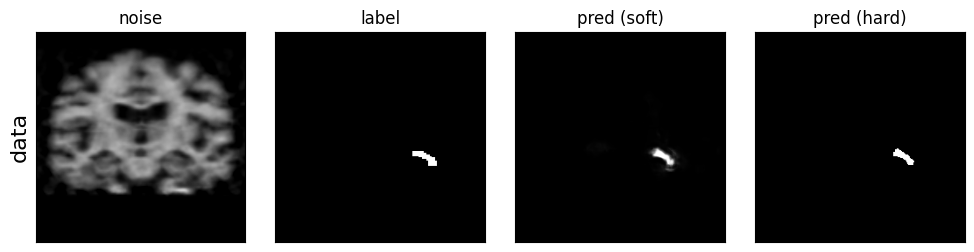

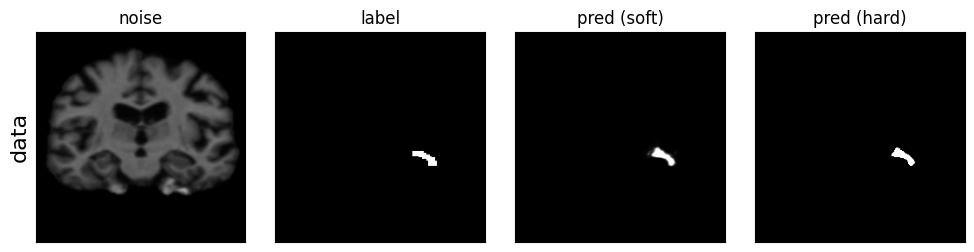

In [6]:
image, label, support_images, support_labels, img, under_img, under_kspace, vmax, mask = eval(catgory = 17, acc_factor = 2.0, center_fraction = 0.05)

In [8]:
def denoise(under_img=under_img, under_kspace=under_kspace, mask=mask):
  ###############################################
  # Configurations
  ###############################################
  problem = 'Fourier_CS_3d_admm_tv'
  config_name = 'fastmri_knee_320_ncsnpp_continuous'
  sde = 'VESDE'
  num_scales = 1000
  ckpt_num = 95
  N = num_scales

  if sde.lower() == 'vesde':
    # from configs.ve import fastmri_knee_320_ncsnpp_continuous as configs
    configs = importlib.import_module(f"configs.ve.{config_name}")
    ckpt_filename = f"/DiffusionMBIR/exp/ve/fastmri_knee_320_ncsnpp_continuous/checkpoint_95.pth"
    config = configs.get_config()
    config.model.num_scales = num_scales
    sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
    sde.N = N
    sampling_eps = 1e-5

  config.device = device

  img_size = 240
  h = w = 240
  batch_size = 1
  config.training.batch_size = batch_size
  predictor = ReverseDiffusionPredictor
  corrector = LangevinCorrector
  probability_flow = False
  snr = 0.16
  n_steps = 1

  # parameters for Fourier CS recon
  mask_type = 'uniform1d'
  use_measurement_noise = False
  # acc_factor = 6.0 ######################################################################## 采样速率
  # center_fraction = 0.15

  # ADMM TV parameters
  lamb_list = [0.005]
  rho_list = [0.01]

  random_seed = 0

  sigmas = mutils.get_sigmas(config)
  scaler = datasets.get_data_scaler(config)
  inverse_scaler = datasets.get_data_inverse_scaler(config)
  score_model = mutils.create_model(config)

  optimizer = get_optimizer(config, score_model.parameters())
  ema = ExponentialMovingAverage(score_model.parameters(),
                                decay=config.model.ema_rate)
  state = dict(step=0, optimizer=optimizer,
              model=score_model, ema=ema)
  state = restore_checkpoint(ckpt_filename, state, config.device, skip_sigma=True)
  ema.copy_to(score_model.parameters())

  for lamb in lamb_list:
    for rho in rho_list:
        print(f'lambda: {lamb}')
        print(f'rho:    {rho}')

        pc_fouriercs = controllable_generation_TV.get_pc_radon_ADMM_TV_mri(sde,
                                                                          predictor, corrector,
                                                                          inverse_scaler,
                                                                          mask=mask,
                                                                          lamb_1=lamb,
                                                                          rho=rho,
                                                                          img_shape=img.shape,
                                                                          snr=snr,
                                                                          n_steps=n_steps,
                                                                          probability_flow=probability_flow,
                                                                          continuous=config.training.continuous)

        x = pc_fouriercs(score_model, scaler(under_img), measurement=under_kspace)

  return x

In [10]:
x= denoise(under_img=under_img, under_kspace=under_kspace, mask=mask)

loaded checkpoint dir from /DiffusionMBIR/exp/ve/fastmri_knee_320_ncsnpp_continuous/checkpoint_95.pth
lambda: 0.005
rho:    0.01


100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


In [11]:
for i, recon_img in enumerate(x):
    print(recon_img.size())
    print(recon_img.mean())

    print(image.size())
    print(image.mean())

    print(img[i].size())
    print(img[i].mean())

    print(under_img[i].size())
    print(under_img.mean())

torch.Size([1, 240, 240])
tensor(0.2289, device='cuda:0')
torch.Size([1, 240, 240])
tensor(0.1299, device='cuda:0')
torch.Size([1, 240, 240])
tensor(0.1299, device='cuda:0')
torch.Size([1, 240, 240])
tensor(0.2289, device='cuda:0')


tensor(0.1299, device='cuda:0')
tensor(0.1299, device='cuda:0')
tensor(0.1299, device='cuda:0')


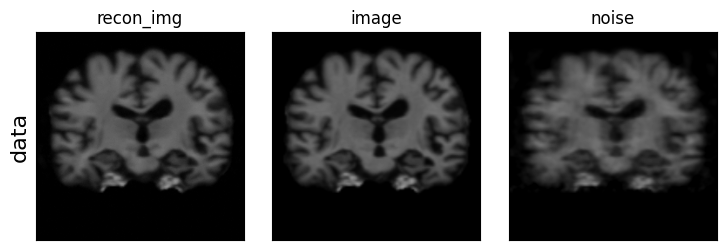

In [12]:
image_pro = image
recon_img_pro = x[0]*(vmax + 1e-5)
under_img_pro = under_img[0]*(vmax + 1e-5)

print(image_pro.mean())
print(recon_img_pro.mean())
print(under_img_pro.mean())

visualize_tensors({'data': [recon_img_pro, image_pro, under_img_pro]}, col_wrap=3, col_names=['recon_img', 'image', 'noise'])

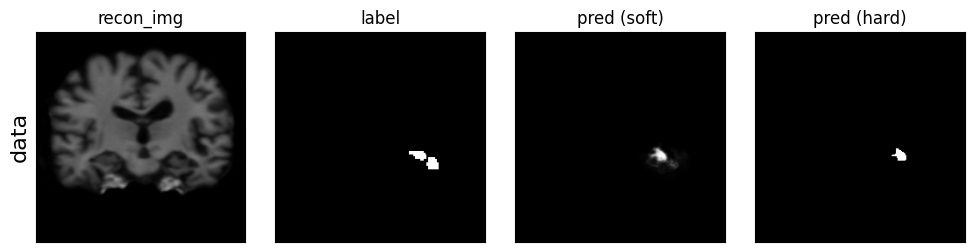

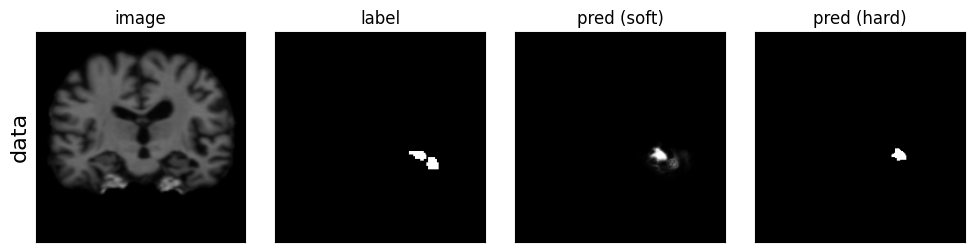

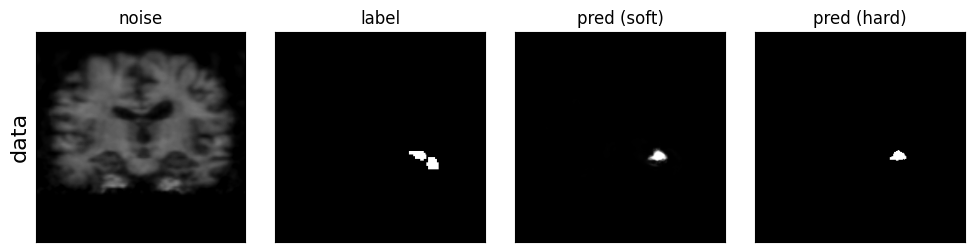

In [13]:
from UniverSeg.universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

# 推理recon_img ###############################################
query = recon_img_pro
# run inference
logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)
# visualize
res = {'data': [query, label, pred, pred > 0.5]}
titles = col_names=['recon_img', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

# 推理原始图像 ###############################################
query = image_pro
# run inference
logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)
# visualize
res = {'data': [query, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

# 推理损坏图像 ###############################################
query = under_img_pro
# run inference
logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)
# visualize
res = {'data': [query, label, pred, pred > 0.5]}
titles = col_names=['noise', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)